Model has 232,564 parameters.


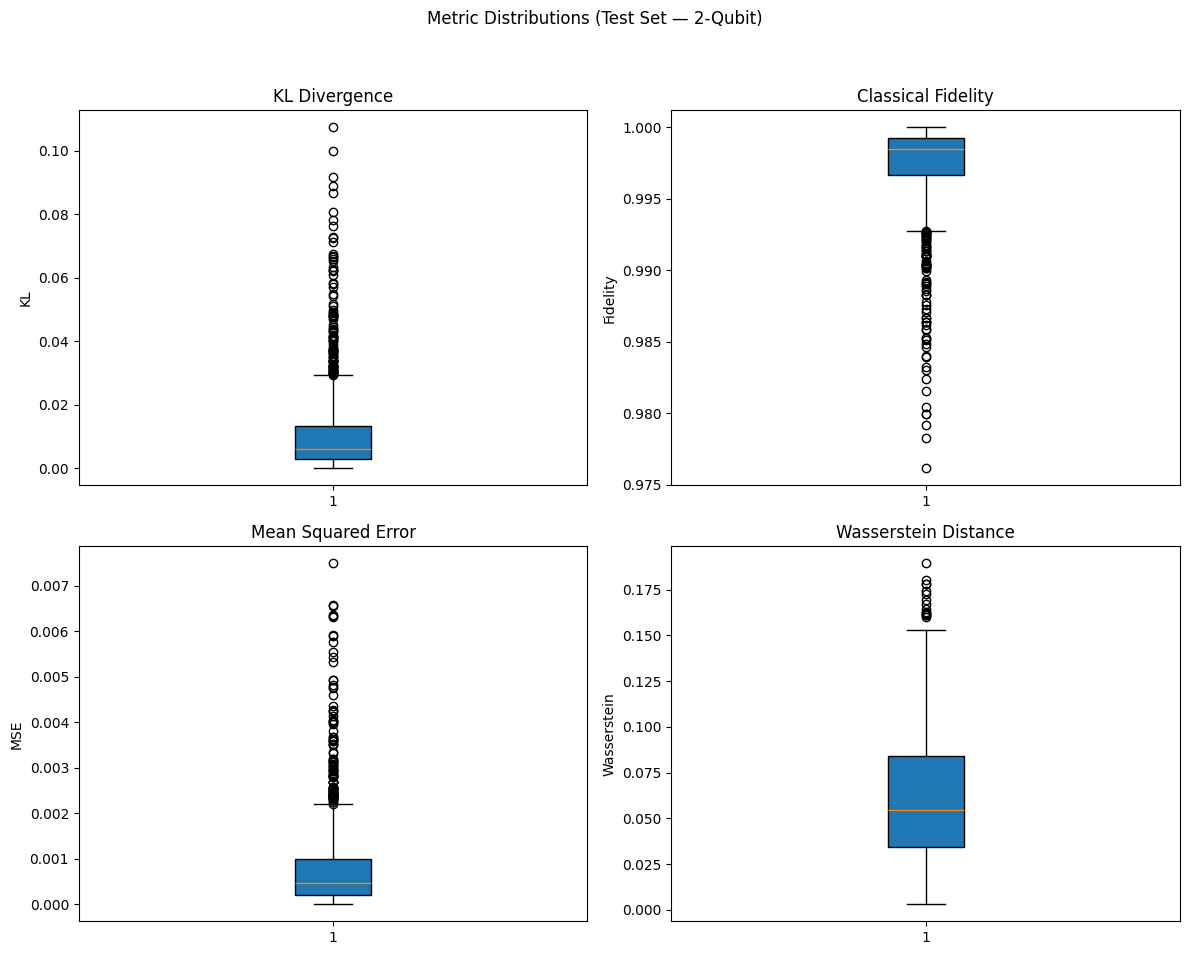

2-Qubit Summary:
  KL Divergence      mean 0.01126, median 0.00614, max 0.10733
  Fidelity           mean 0.99729, median 0.99847, min 0.97617
  MSE                mean 0.00086, median 0.00047, max 0.00749
  Wasserstein (W1)   mean 0.06194, median 0.05460, max 0.18930
Model has 936,440 parameters.


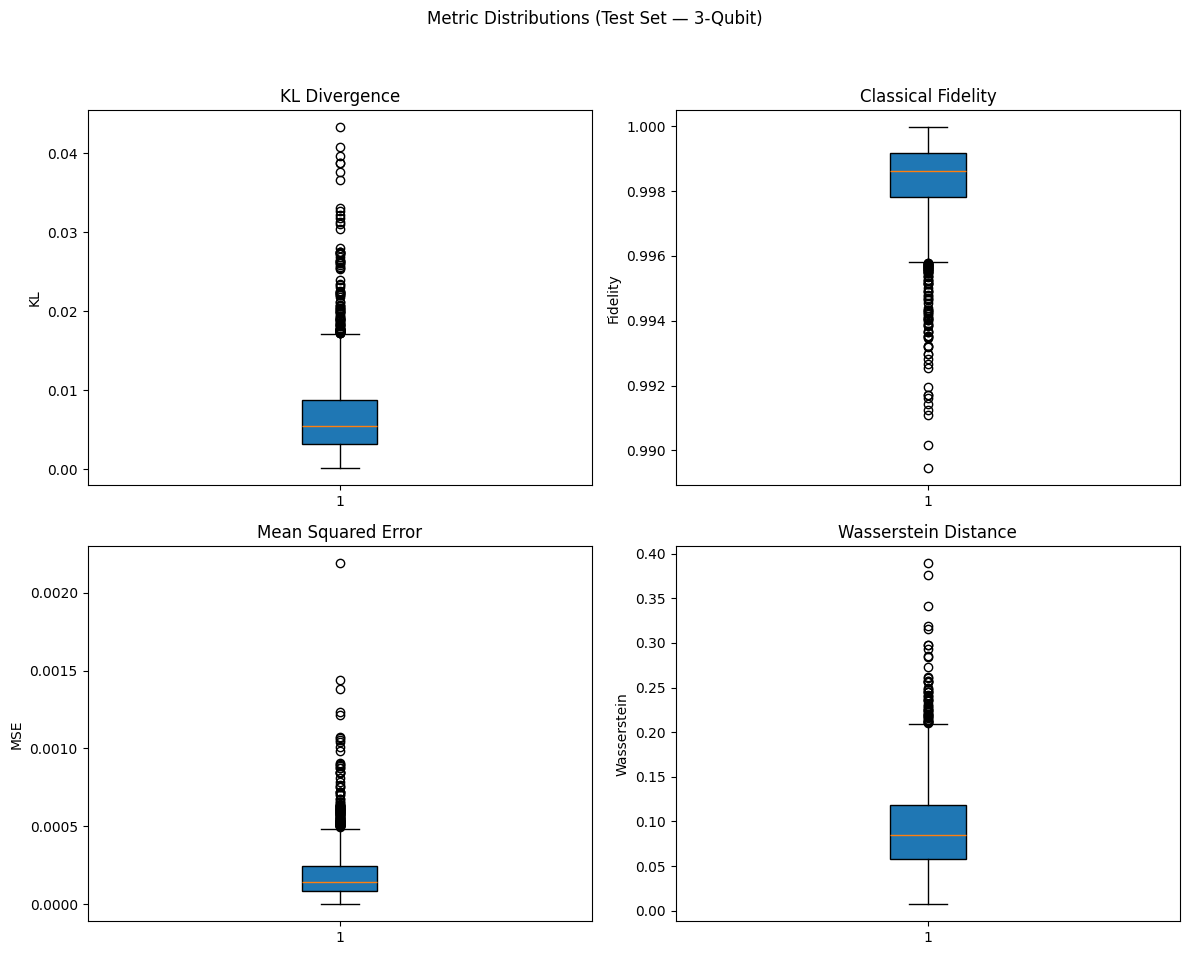

3-Qubit Summary:
  KL Divergence      mean 0.00689, median 0.00546, max 0.04329
  Fidelity           mean 0.99830, median 0.99861, min 0.98945
  MSE                mean 0.00019, median 0.00014, max 0.00219
  Wasserstein (W1)   mean 0.09376, median 0.08469, max 0.38904
Model has 2,406,616 parameters.


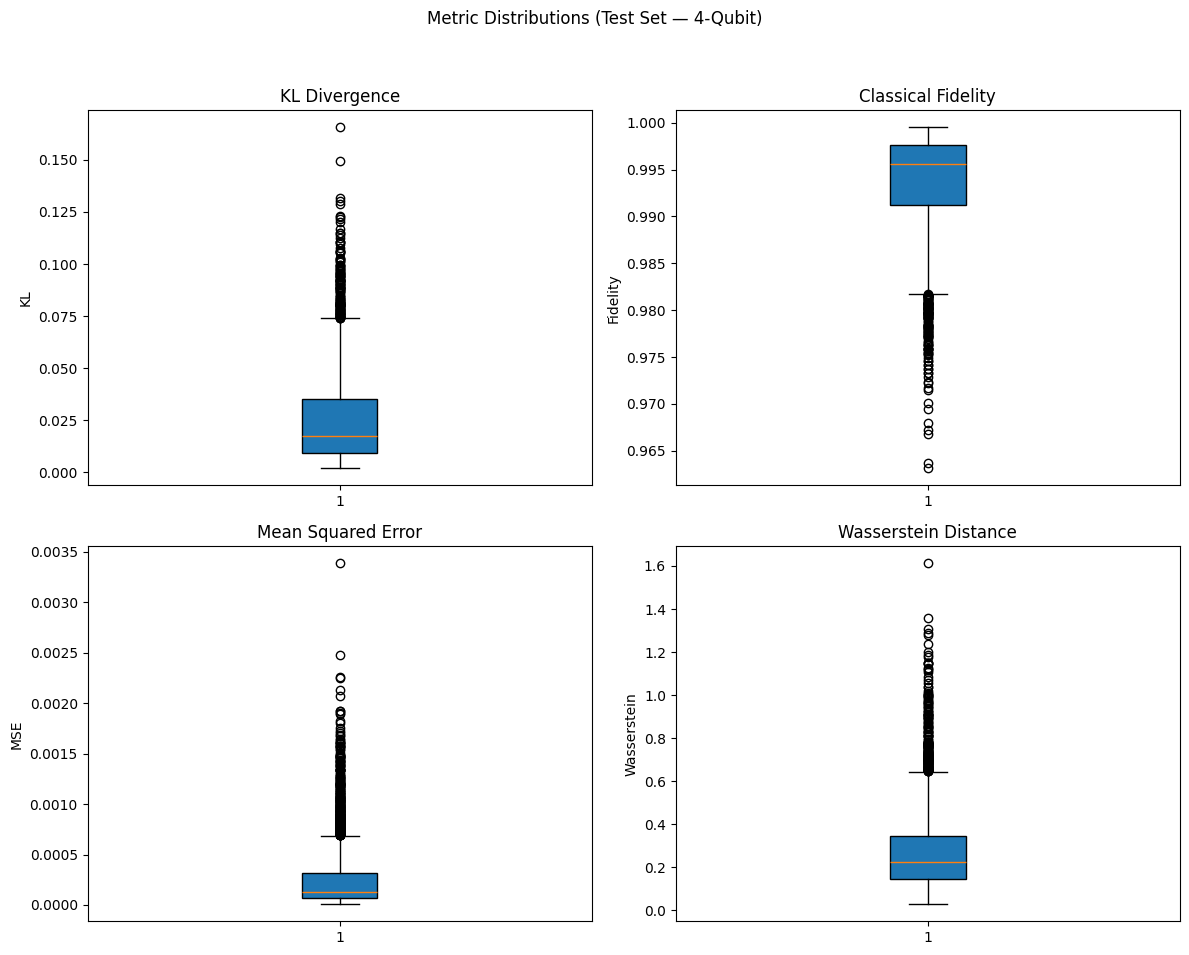

4-Qubit Summary:
  KL Divergence      mean 0.02533, median 0.01763, max 0.16561
  Fidelity           mean 0.99371, median 0.99559, min 0.96313
  MSE                mean 0.00025, median 0.00013, max 0.00338
  Wasserstein (W1)   mean 0.27723, median 0.22511, max 1.61200
Model has 4,926,200 parameters.


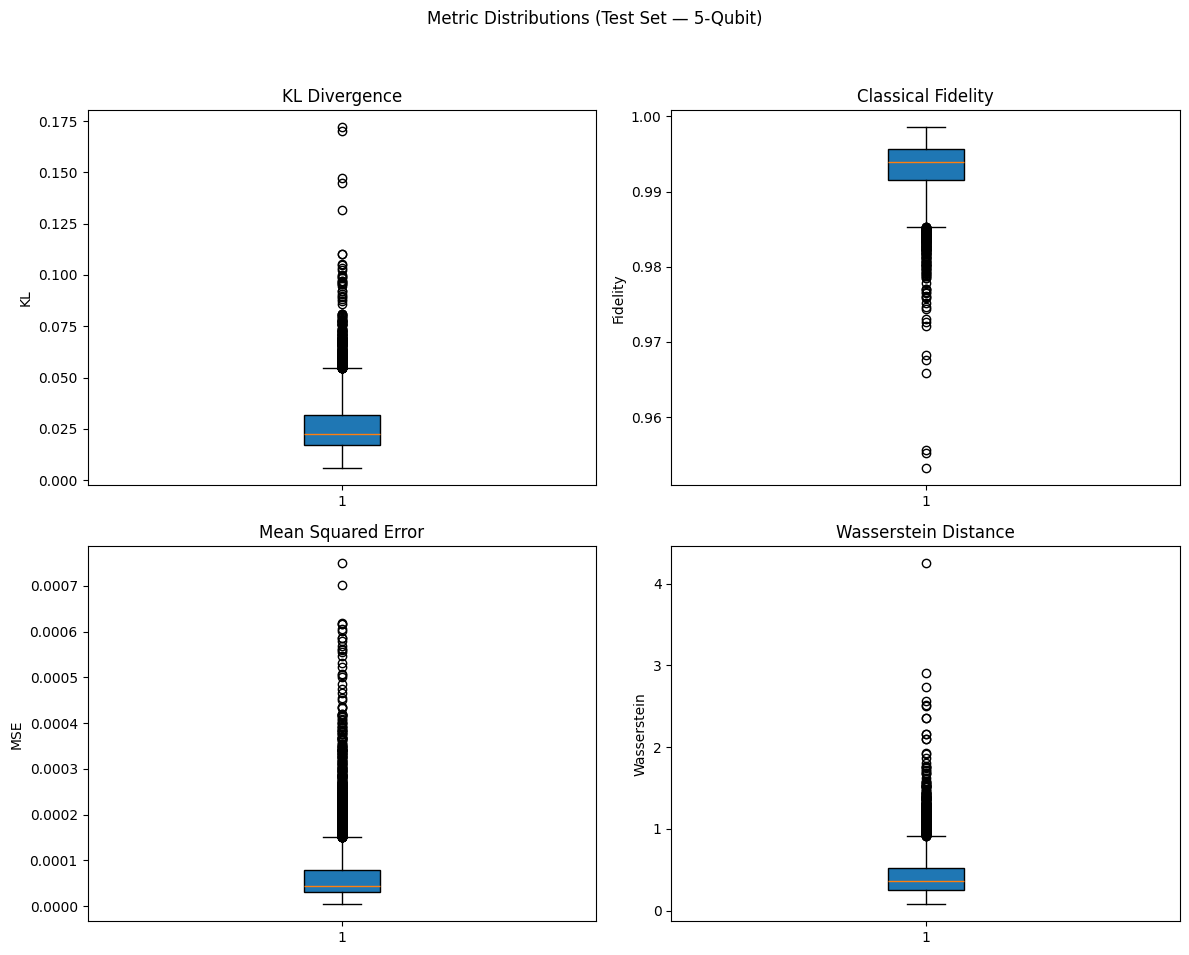

5-Qubit Summary:
  KL Divergence      mean 0.02605, median 0.02258, max 0.17194
  Fidelity           mean 0.99317, median 0.99399, min 0.95319
  MSE                mean 0.00007, median 0.00004, max 0.00075
  Wasserstein (W1)   mean 0.42958, median 0.36447, max 4.24911


In [1]:
import os
import random
import numpy as np
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, Dropout, BatchNorm1d, LayerNorm
from torch_geometric.nn import TransformerConv, global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import networkx as nx


def wasserstein_vec(p, q):
    x = np.arange(p.shape[1])
    p_np = p.detach().cpu().numpy()
    q_np = q.detach().cpu().numpy()
    return np.array([
        wasserstein_distance(x, x, p_np[i], q_np[i])
        for i in range(p_np.shape[0])
    ])


def mse_vec(p, q):
    if p.shape != q.shape:
        if p.ndim == 2 and p.shape[0] == 1 and q.ndim == 1:
            q = q.unsqueeze(0)
        elif q.ndim == 2 and q.shape[0] == 1 and p.ndim == 1:
            p = p.unsqueeze(0)
        else:
            raise ValueError(f"Shape mismatch in mse_vec: p {p.shape}, q {q.shape}")
    return ((p - q) ** 2).mean(dim=1)

    
def normalize(tensor, eps=1e-8):
    tensor = torch.clamp(tensor, min=0)
    if tensor.dim() == 1:
        total = tensor.sum()
        if total < eps:
            tensor = torch.ones_like(tensor) / tensor.numel()
            total = tensor.sum()
        return tensor / (total + eps)
    elif tensor.dim() == 2:
        total = tensor.sum(dim=1, keepdim=True)
        mask = (total < eps).squeeze()
        if mask.any():
            tensor[mask] = 1.0 / tensor.shape[1]
            total = tensor.sum(dim=1, keepdim=True)
        return tensor / (total + eps)
    else:
        raise ValueError("Input tensor not 1d/2d.")


def kl_divergence_vec(p, q, eps=1e-8):
    p = p + eps
    q = q + eps
    return (p * (p.log() - q.log())).sum(dim=-1)


def classical_fidelity_vec(p, q, eps=1e-8):
    p = p + eps
    q = q + eps
    return (p.sqrt() * q.sqrt()).sum(dim=1)


def add_topological_position_feature(data):
    G = to_networkx(data, to_undirected=False)
    topo_order = list(nx.topological_sort(G))
    pos = torch.zeros((data.num_nodes, 1), dtype=torch.float32)
    for i, node_id in enumerate(topo_order):
        pos[node_id] = i / (len(topo_order) - 1) if len(topo_order) > 1 else 0.0
    data.x = torch.cat([data.x, pos], dim=1)
    return data


def stratified_split(data, key_fn, train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42):
    random.seed(seed)
    keys = [key_fn(g) for g in data]
    key_to_indices = {}
    for idx, k in enumerate(keys):
        key_to_indices.setdefault(k, []).append(idx)
    train_idx, val_idx, test_idx = [], [], []
    for indices in key_to_indices.values():
        random.shuffle(indices)
        n = len(indices)
        n_train = int(n * train_frac)
        n_val = int(n * val_frac)
        train_idx.extend(indices[:n_train])
        val_idx.extend(indices[n_train:n_train + n_val])
        test_idx.extend(indices[n_train + n_val:])
    return [data[i] for i in train_idx], [data[i] for i in val_idx], [data[i] for i in test_idx]


DATASET_ROOT = "../datasets"
CIRCUIT_CLASSES = ["classA", "classB"]
NOISE_TYPES = ["noiseless", "noisy"]


def load_single_dataset(n_qubits, noise_type, circuit_class):
    fname = f"dataset_{n_qubits}q_{noise_type}_{circuit_class}.pt"
    fpath = os.path.join(DATASET_ROOT, f"{n_qubits}-qubit", noise_type, circuit_class, fname)
    data_list = torch.load(fpath)
    for g in data_list:
        g.circuit_class = circuit_class
        g.noise_regime = noise_type
        g.n_qubits = n_qubits
        g = add_topological_position_feature(g)
    return data_list


def load_all_for_qubit(n_qubits):
    full_data = []
    for cls in CIRCUIT_CLASSES:
        for noise in NOISE_TYPES:
            full_data.extend(load_single_dataset(n_qubits, noise, cls))
    random.shuffle(full_data)
    return full_data


class GraphTransformer(torch.nn.Module):
    def __init__(self, node_in_dim, global_u_dim, edge_attr_dim,
                 hidden_dim, output_dim, n_qubits, heads=3, dropout=0.1):
        super().__init__()
        self.input_dim = node_in_dim + global_u_dim
        self.convs = torch.nn.ModuleList([
            TransformerConv(
                self.input_dim if i == 0 else hidden_dim * heads,
                hidden_dim,
                heads=heads,
                dropout=dropout,
                edge_dim=edge_attr_dim
            )
            for i in range(n_qubits)
        ])
        self.bns = torch.nn.ModuleList([
            BatchNorm1d(hidden_dim * heads)
            for _ in range(n_qubits)
        ])
        self.norm = LayerNorm(hidden_dim * heads)
        self.dropout = Dropout(dropout)
        self.relu = ReLU()
        self.mlp = Sequential(
            Linear(2 * hidden_dim * heads, 2 * hidden_dim * heads),
            ReLU(),
            Dropout(dropout),
            Linear(2 * hidden_dim * heads, hidden_dim * heads),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim * heads, output_dim)
        )

    def forward(self, data):
        x, edge_index, batch, u, edge_attr = (
            data.x, data.edge_index, data.batch, data.u, data.edge_attr
        )
        if u.dim() == 1:
            batch_size = batch.max().item() + 1
            u = u.view(batch_size, -1)
        u_per_node = u[batch]
        x = torch.cat([x, u_per_node], dim=1)
        x_in = x
        for i in range(len(self.convs)):
            x_out = self.dropout(
                self.relu(self.bns[i](self.convs[i](x_in, edge_index, edge_attr)))
            )
            if i > 0:
                x_out = x_out + x_in
            x_in = x_out
        x_final = self.norm(x_in)
        x_mean = global_mean_pool(x_final, batch)
        x_max = global_max_pool(x_final, batch)
        x_pooled = torch.cat([x_mean, x_max], dim=1)
        return self.mlp(x_pooled)


def build_gnn_model(sample, hidden_dim_2q, heads, dropout):
    node_in_dim   = sample.x.shape[1]
    global_u_dim  = sample.u.shape[0]
    edge_attr_dim = sample.edge_attr.shape[1]
    output_dim    = sample.y.shape[-1]
    n_qubits      = sample.n_qubits
    hidden_dim    = int(hidden_dim_2q * (1 + 0.75 * (n_qubits - 2)))

    model = GraphTransformer(
        node_in_dim=node_in_dim,
        global_u_dim=global_u_dim,
        edge_attr_dim=edge_attr_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        n_qubits=n_qubits,
        heads=heads,
        dropout=dropout
    )
    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters.")
    return model

MODEL_ROOT = "../models/gnn_models"


def plot_metric_grid(model, loader, qubit_size):
    model.eval()
    kl_list, fi_list, mse_list, w1_list = [], [], [], []

    with torch.no_grad():
        for batch in loader:
            pred   = model(batch)
            target = batch.y

            if pred.dim() == 1:
                pred = pred.unsqueeze(0)
            if target.dim() == 1:
                target = target.unsqueeze(0)

            pred_prob   = F.softmax(pred, dim=1)
            target_prob = normalize(target)

            if pred_prob.shape != target_prob.shape:
                continue

            kl_vals  = kl_divergence_vec(target_prob, pred_prob)
            fi_vals  = classical_fidelity_vec(target_prob, pred_prob)
            mse_vals = mse_vec(pred_prob, target_prob)
            w1_vals  = wasserstein_vec(pred_prob, target_prob)

            kl_list .extend(kl_vals .detach().cpu().numpy())
            fi_list .extend(fi_vals .detach().cpu().numpy())
            mse_list.extend(mse_vals.detach().cpu().numpy())
            w1_list .extend(w1_vals)

    if not kl_list:
        return

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Metric Distributions (Test Set — {qubit_size}-Qubit)", y=0.98)

    axes[0, 0].boxplot(kl_list,  patch_artist=True)
    axes[0, 0].set_title("KL Divergence")
    axes[0, 0].set_ylabel("KL")

    axes[0, 1].boxplot(fi_list,  patch_artist=True)
    axes[0, 1].set_title("Classical Fidelity")
    axes[0, 1].set_ylabel("Fidelity")

    axes[1, 0].boxplot(mse_list, patch_artist=True)
    axes[1, 0].set_title("Mean Squared Error")
    axes[1, 0].set_ylabel("MSE")

    axes[1, 1].boxplot(w1_list,  patch_artist=True)
    axes[1, 1].set_title("Wasserstein Distance")
    axes[1, 1].set_ylabel("Wasserstein")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"{qubit_size}-Qubit Summary:")
    print(f"  KL Divergence      mean {np.mean(kl_list):.5f}, median {np.median(kl_list):.5f}, max {np.max(kl_list):.5f}")
    print(f"  Fidelity           mean {np.mean(fi_list):.5f}, median {np.median(fi_list):.5f}, min {np.min(fi_list):.5f}")
    print(f"  MSE                mean {np.mean(mse_list):.5f}, median {np.median(mse_list):.5f}, max {np.max(mse_list):.5f}")
    print(f"  Wasserstein (W1)   mean {np.mean(w1_list):.5f}, median {np.median(w1_list):.5f}, max {np.max(w1_list):.5f}")


for qubit_size in [2, 3, 4, 5]:
    full_data = load_all_for_qubit(qubit_size)

    def bitstring_argmax(g):
        return int(torch.argmax(g.y).item())

    train_data, val_data, test_data = stratified_split(
        full_data, key_fn=bitstring_argmax,
        train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42
    )
    if not test_data:
        continue

    sample = train_data[0]
    model  = build_gnn_model(sample, hidden_dim_2q=48, heads=3, dropout=0.1)
    model_path = os.path.join(MODEL_ROOT, f"{qubit_size}q_gnn.pt")
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.to('cpu')

    expected_dim = 2 ** qubit_size
    if model.mlp[-1].out_features != expected_dim or test_data[0].y.numel() != expected_dim:
        continue

    test_loader = DataLoader(test_data, batch_size=1)
    plot_metric_grid(model, test_loader, qubit_size)